# Imports

In [4]:
import numpy as np

import eleanor
import lightkurve as lk
from seismolab.OC import OCFitter

import astropy.units as u
from astropy.table import Table, vstack, Column
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

CLEAN_ITURBIDE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/cleaned-iturbide.ecsv"
CLEAN_ZTF_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/cleaned-ztf-flux.ecsv"

# ZTF_G_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zg-flux.ecsv"
# ZTF_R_DATA_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zr-flux.ecsv"
CLEAN_ZTF_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/cleaned-ztf-flux.ecsv"

ITURBIDE_LOCATION = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
ATO_NAME = "ATO J339.9469+45.1464"
ATO_COORD = SkyCoord.from_name(ATO_NAME)

# Load Iturbide data

In [5]:
iturbideData = Table.read(CLEAN_ITURBIDE_PATH)
iturbideData.remove_column('time')
iturbideData.rename_column('hjd', 'time')
iturbideData

mag,err,filter,time,ltt_corr,obsv_date,norm_flux,norm_ferr
mag,mag,,,,,,mag
float64,float64,str18,Time,TimeDelta,str10,float64,float64
1.2027999999999999,0.0206155281280883,Iturbide:Luminance,2459880.841608384,0.0033265544398984777,2022-10-28,1.2238269144863219,0.023237539716311435
1.3013000000000012,0.03956008088970497,Iturbide:Luminance,2459922.5373161673,0.0012063471745832476,2022-12-09,1.11768648628847,0.04072422713098342
1.2391000000000005,0.0206155281280883,Iturbide:Luminance,2459880.842311,0.003326530177332098,2022-10-28,1.1835864919618604,0.022473470544809505
1.2182999999999993,0.0206155281280883,Iturbide:Luminance,2459924.539855498,0.0010780078240699316,2022-12-11,1.2064796473587158,0.022908156693209343
1.2197999999999993,0.0206155281280883,Iturbide:Luminance,2459880.843009906,0.003326506041772801,2022-10-28,1.2048139849918464,0.02287652975728733
1.1997999999999998,0.01969771560359221,Iturbide:Luminance,2459924.540559342,0.0010779623057632398,2022-12-11,1.2272131493198564,0.02226442803910769
1.251100000000001,0.022472205054244233,Iturbide:Luminance,2459880.8437087024,0.0033264819089261146,2022-10-28,1.170577035963137,0.024228212220124983
1.2329000000000008,0.01969771560359221,Iturbide:Luminance,2459924.5412554373,0.0010779172855032103,2022-12-11,1.19036459177042,0.021595911686949115


In [6]:
ORBITAL_PERIOD = iturbideData.meta['period'] * u.day
ORBITAL_PERIOD

<Quantity 0.33356544 d>

# TESS

## Search lightkurve

In [7]:
pxFileResults = lk.search_targetpixelfile(target=ATO_NAME)
pxFileResults

No data found for target "ATO J339.9469+45.1464".


SearchResult containing 0 data products.

In [8]:
lcSearchResults = lk.search_lightcurve(target=ATO_NAME)
lcSearchResults

No data found for target "ATO J339.9469+45.1464".


SearchResult containing 0 data products.

## `eleanor` photometry

In [9]:
# star = eleanor.Source(coords=objCoord)
eleanorStar = eleanor.multi_sectors(coords=ATO_COORD, sectors='all')

Found star in Sector(s) 16 56 57 76


No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.


In [10]:
sectorsData: list[eleanor.targetdata.TargetData] = [eleanor.TargetData(s, do_pca=True) for s in eleanorStar]

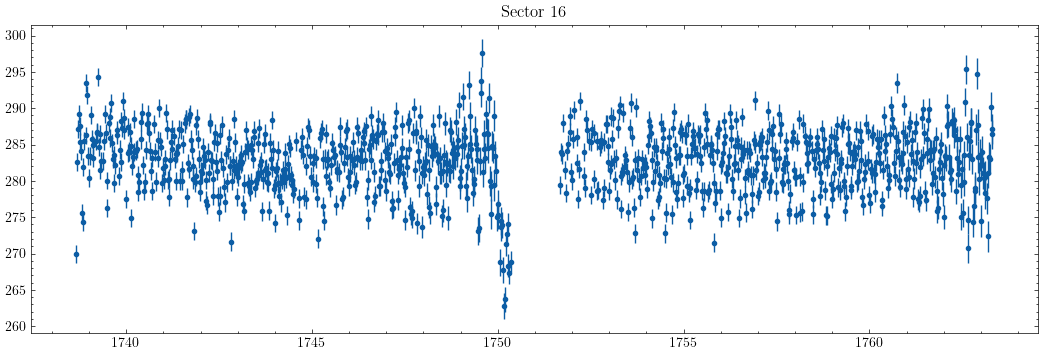

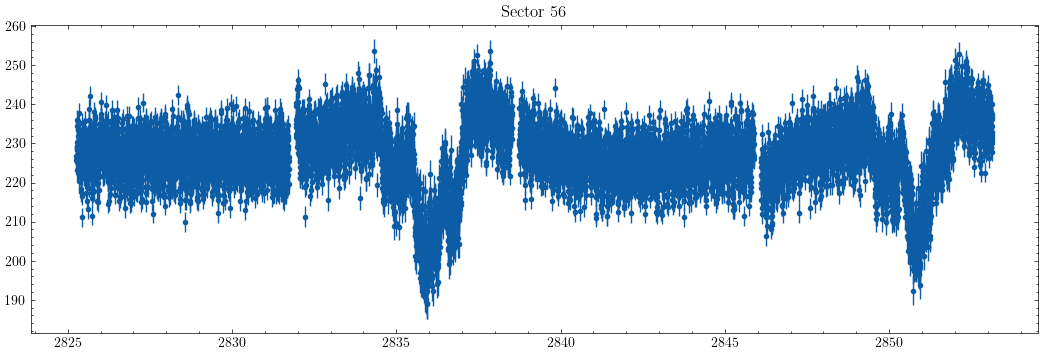

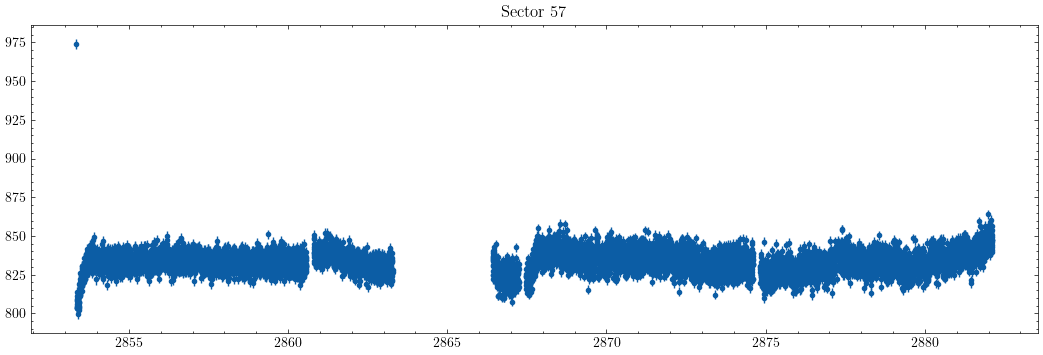

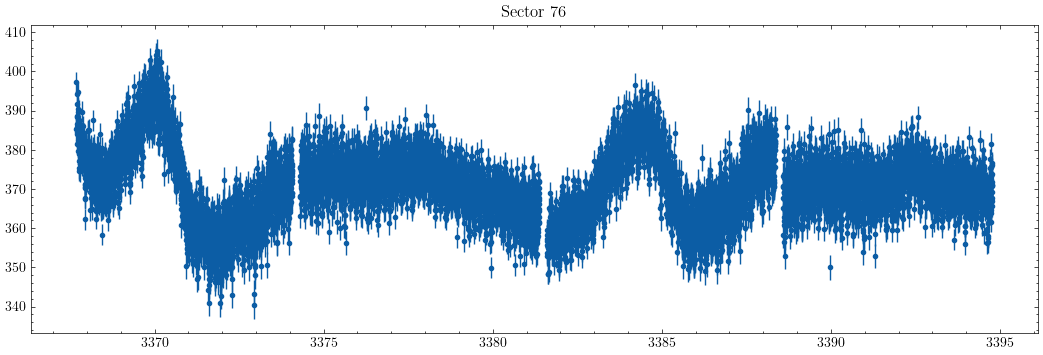

In [11]:
for eleanorData in sectorsData:
    qualityMask = eleanorData.quality == 0
    plt.figure(figsize=(13, 4))
    plt.errorbar(eleanorData.time[qualityMask], eleanorData.pca_flux[qualityMask], eleanorData.flux_err[qualityMask], marker='.', linestyle='none')
    plt.title(f"Sector {eleanorData.source_info.sector}")
plt.show()

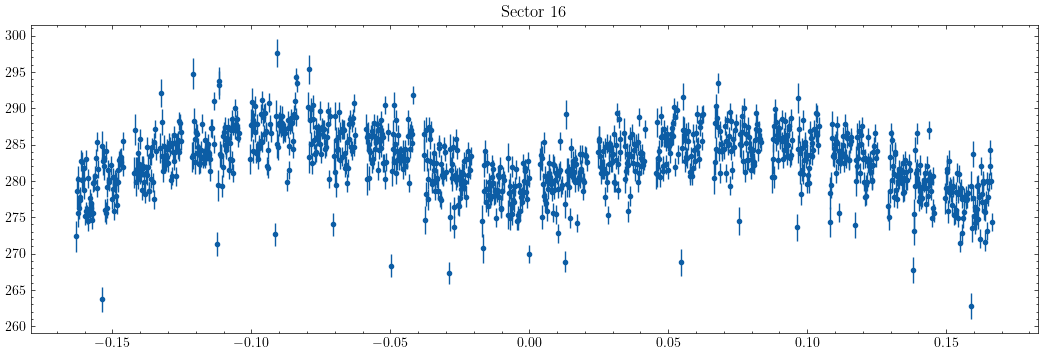

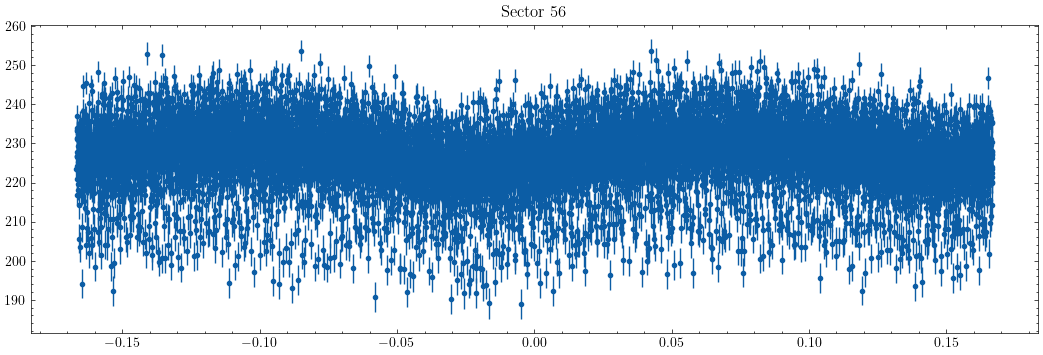

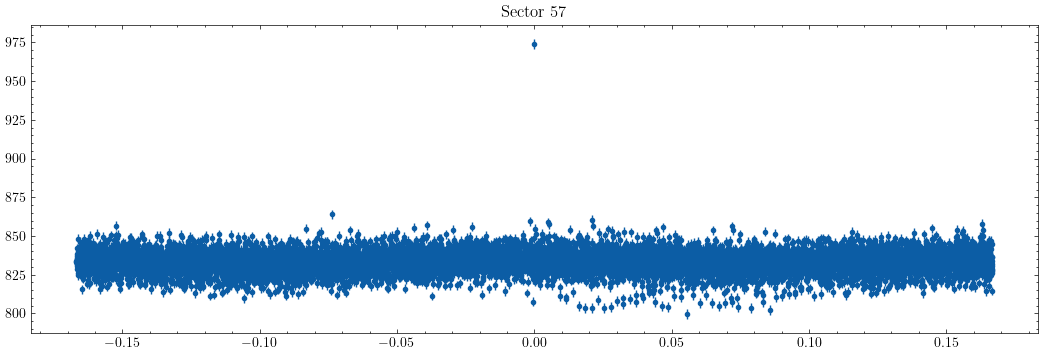

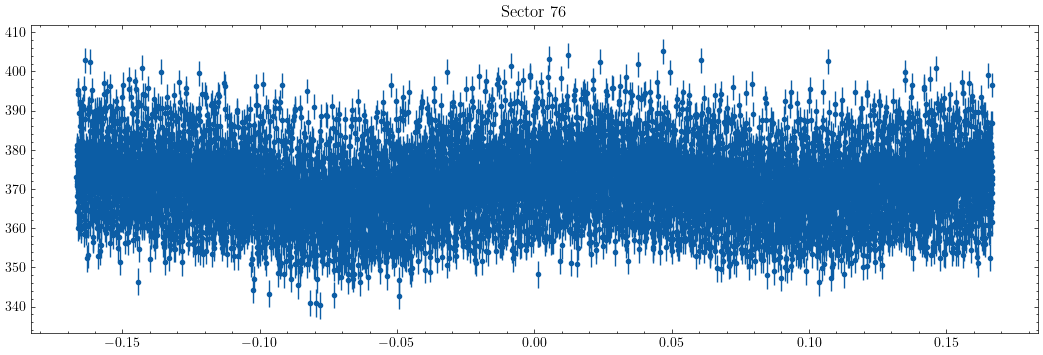

In [12]:
for eleanorData in sectorsData:
    qualityMask = eleanorData.quality == 0
    ts = TimeSeries(time=Time(eleanorData.time[qualityMask], format='btjd'), data={'flux': eleanorData.pca_flux[qualityMask], 'flux_err': eleanorData.flux_err[qualityMask]}).fold(ORBITAL_PERIOD)

    plt.figure(figsize=(13, 4))
    plt.errorbar(ts.time.value, ts['flux'], ts['flux_err'], marker='.', linestyle='none')
    plt.title(f"Sector {eleanorData.source_info.sector}")
plt.show()

## $O-C$

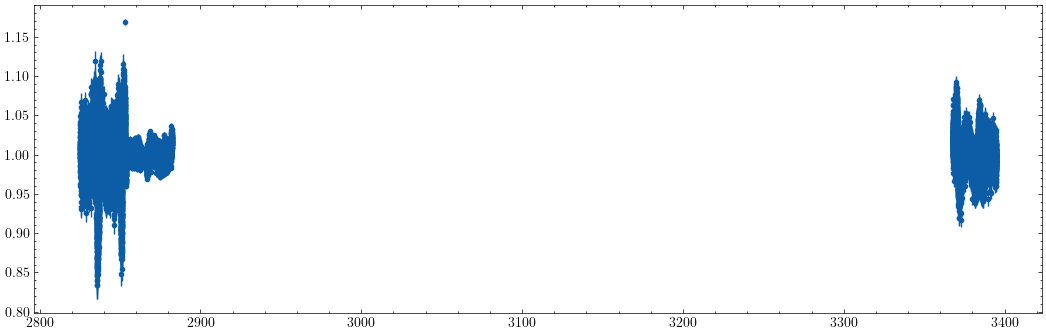

In [13]:
# allSectors_mask = np.concatenate([s.quality == 0 for s in sectorsData])
# allSectors_time = np.concatenate([s.time for s in sectorsData])[allSectors_mask]
# allSectors_flux = np.concatenate([s.pca_flux for s in sectorsData])[allSectors_mask]
# allSectors_ferr = np.concatenate([s.flux_err for s in sectorsData])[allSectors_mask]

allSectors_time = np.ndarray(shape=0)
allSectors_flux = np.ndarray(shape=0)
allSectors_ferr = np.ndarray(shape=0)
for s in sectorsData[1:]:
    qualityMask = s.quality == 0
    time = s.time[qualityMask]
    flux = s.pca_flux[qualityMask]
    ferr = s.flux_err[qualityMask]

    normFactor = np.mean(flux)
    flux /= normFactor
    ferr /= normFactor

    allSectors_time = np.concatenate([allSectors_time, time])
    allSectors_flux = np.concatenate([allSectors_flux, flux])
    allSectors_ferr = np.concatenate([allSectors_ferr, ferr])

plt.figure(figsize=(13, 4))
plt.errorbar(allSectors_time, allSectors_flux, allSectors_ferr, marker='.', linestyle='none')
plt.show()

In [14]:
ORBITAL_PERIOD

<Quantity 0.33356544 d>

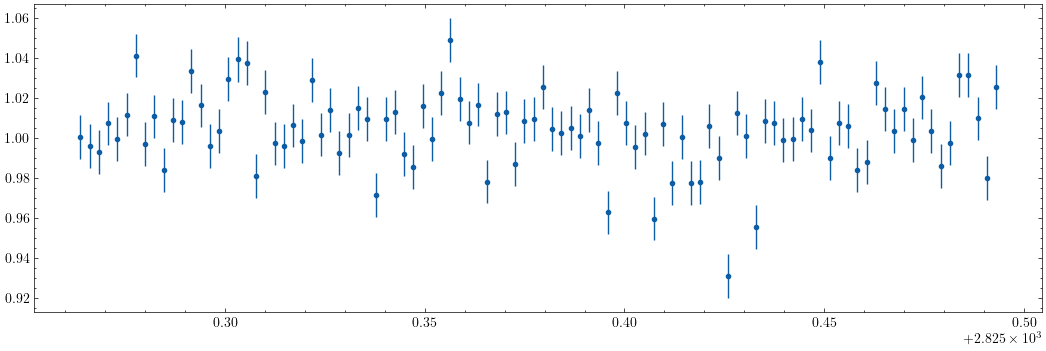

In [15]:
FIRST_WINDOW_SIZE = 100

plt.figure(figsize=(13, 4))
plt.errorbar(allSectors_time[:FIRST_WINDOW_SIZE], allSectors_flux[:FIRST_WINDOW_SIZE], allSectors_ferr[:FIRST_WINDOW_SIZE], marker='.', linestyle='none')
plt.show()

Calculating minima times...


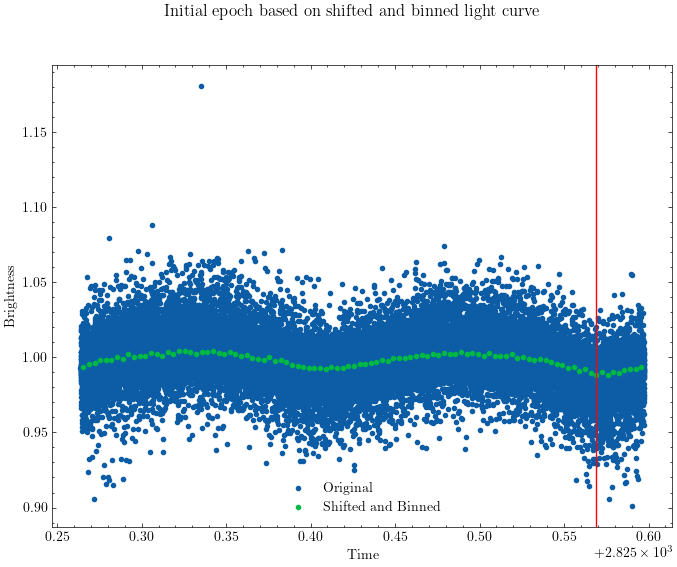

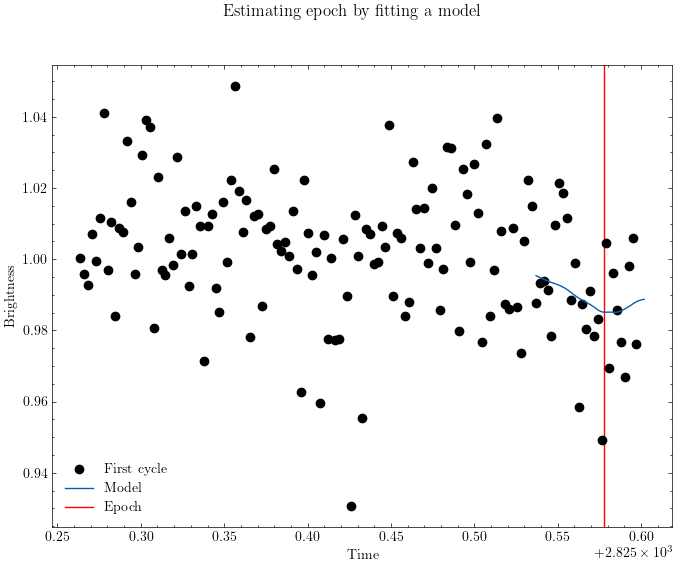

Fitting cycles:   0%|          | 0/233 [00:00<?, ?it/s]

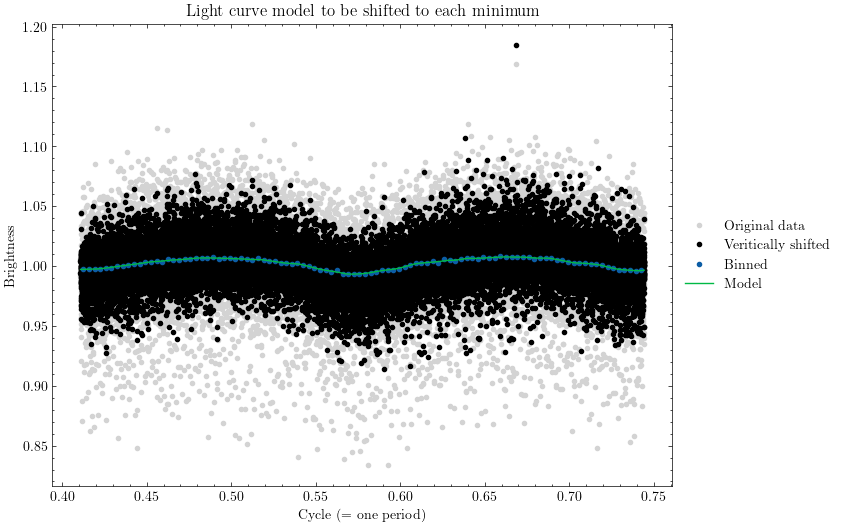

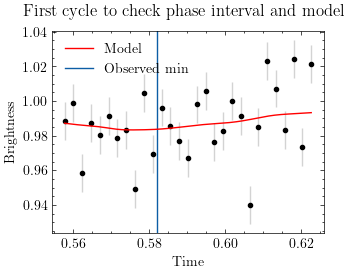

Done!
Calculating the O-C...


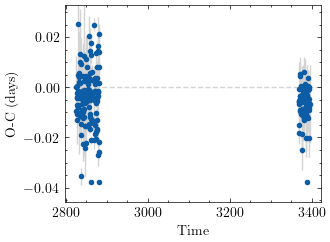

In [16]:
# all sectors

fitter = OCFitter(allSectors_time, allSectors_flux, allSectors_ferr, ORBITAL_PERIOD.value)
mintimes, mintimes_err = fitter.fit_minima(showfirst=True)
# mintimes, mintimes_err = fitter.fit_minima(showfirst=True, fittype='nonparametric', smoothness=-1)
# mintimes, mintimes_err = fitter.fit_minima(showfirst=True, fittype='poly', order=4)
midtimes, oc, oc_err = fitter.calculate_OC(showplot=True)

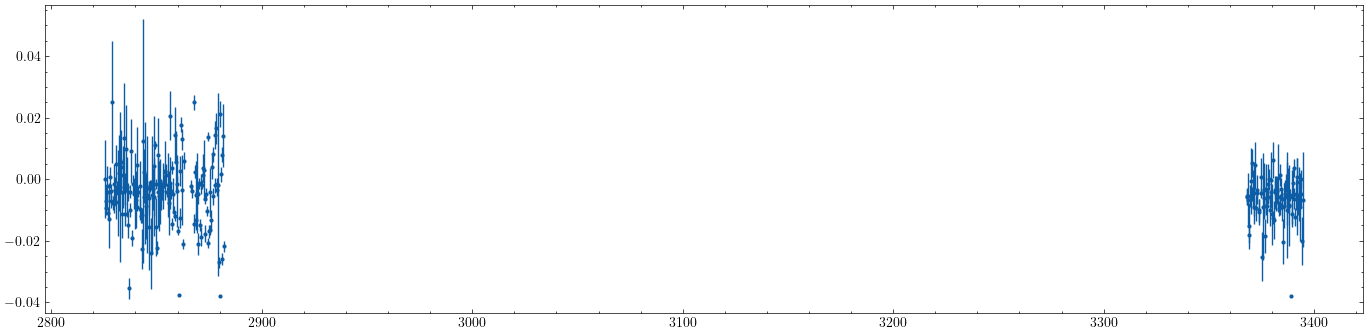

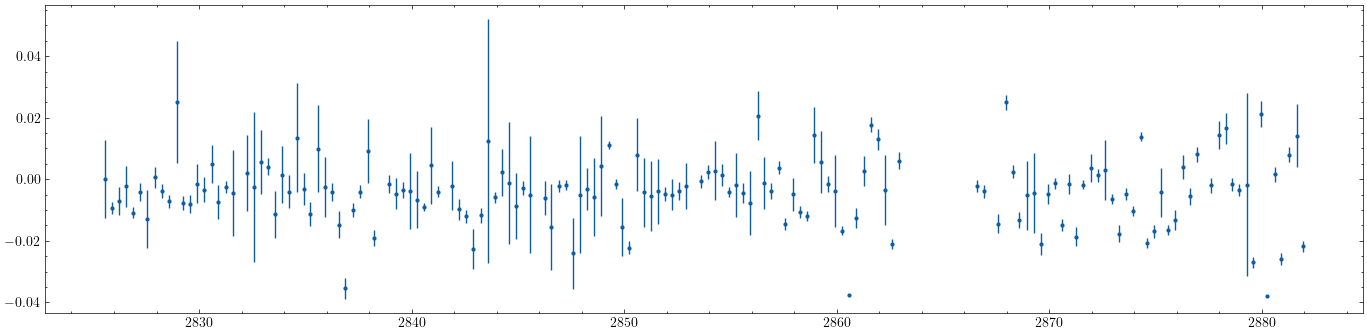

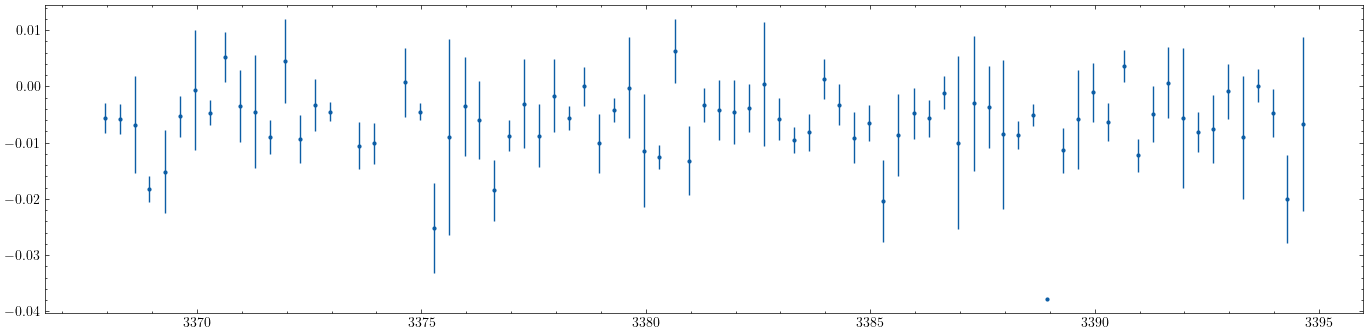

In [17]:
plt.figure(figsize=(17, 4))
plt.errorbar(midtimes, oc, oc_err, marker='.', linestyle='none', markersize=4)

dayMask = midtimes < 3000
plt.figure(figsize=(17, 4))
plt.errorbar(midtimes[dayMask], oc[dayMask], oc_err[dayMask], marker='.', linestyle='none', markersize=4)

plt.figure(figsize=(17, 4))
plt.errorbar(midtimes[~dayMask], oc[~dayMask], oc_err[~dayMask], marker='.', linestyle='none', markersize=4)

plt.show()

# ZTF

In [18]:
ztfData = Table.read(CLEAN_ZTF_PATH)
ztfData.remove_column('time')
ztfData.rename_column('hjd', 'time')
ztfData

mag,err,filter,time,ltt_corr,magzp,norm_flux,norm_ferr,flux,ferr
mag,mag,,,,mag,,mag,,mag
float64,float64,str5,Time,TimeDelta,float64,float64,float64,float64,float64
17.4029655,0.0183366165,ZTF:g,2459855.823404422,--,26.3760471,1.0748268824054272,0.018152372795700807,3883.58343514,65.58847331783878
17.3737259,0.0181318633,ZTF:g,2459171.6813231735,--,26.2424183,1.1041659745512657,0.018439641621359425,3527.58071756,58.91082112787078
17.347332,0.0179516952,ZTF:g,2459059.938682193,--,26.4026089,1.1313368155295236,0.018705661275658557,4189.00385473,69.26150206852135
17.3862724,0.0182190519,ZTF:g,2459853.8260075753,--,26.4263515,1.0914799441631682,0.018315433954740255,4130.77595163,69.31593615489366
17.3823967,0.0181920044,ZTF:g,2459153.6732318965,--,26.4453449,1.0953831096376578,0.018353642683079867,4218.70618825,70.6863427806577
17.3224964,0.0177861098,ZTF:g,2459402.84662591,--,26.3122578,1.1575137535579465,0.01896194179172473,3943.70626167,64.60426785222208
17.358345,0.018026337,ZTF:g,2459068.9482646487,--,26.429224,1.1199192766000492,0.018593874096043437,4249.63470433,70.55613230116217
17.2687778,0.0174406506,ZTF:g,2458388.80883886,--,26.3095112,1.2162240862985692,0.01953673392070678,4133.26604199,66.39444144841066


## $O - C$

### Per band

Processing ZTF:r and ZTF:g separately

Calculating minima times...


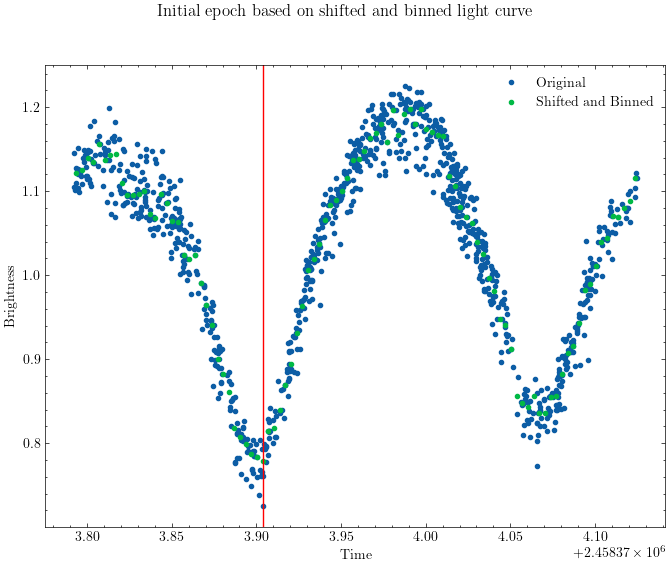

ValueError: zero-size array to reduction operation minimum which has no identity

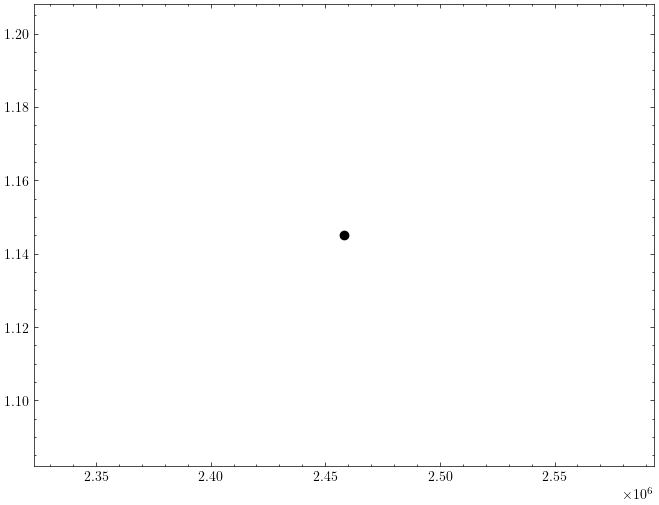

In [20]:
data_ztfr = ztfData[ztfData['filter'] == 'ZTF:r']
fitter_ztfr = OCFitter(data_ztfr['time'].value, data_ztfr['norm_flux'], data_ztfr['norm_ferr'], ORBITAL_PERIOD.value)
mintimes_ztfr, mintimes_err_ztfr = fitter_ztfr.fit_minima(showfirst=True)
midtimes_ztfr, oc_ztfr, oc_err_ztfr = fitter_ztfr.calculate_OC(showplot=True)

Calculating minima times...


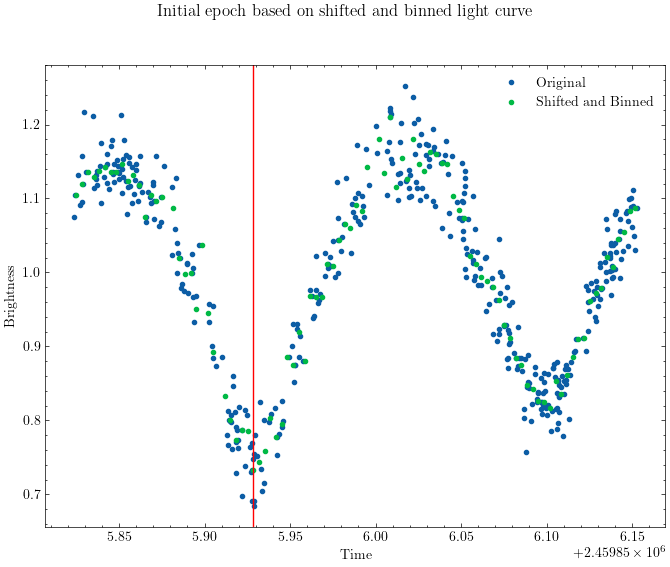

ValueError: zero-size array to reduction operation minimum which has no identity

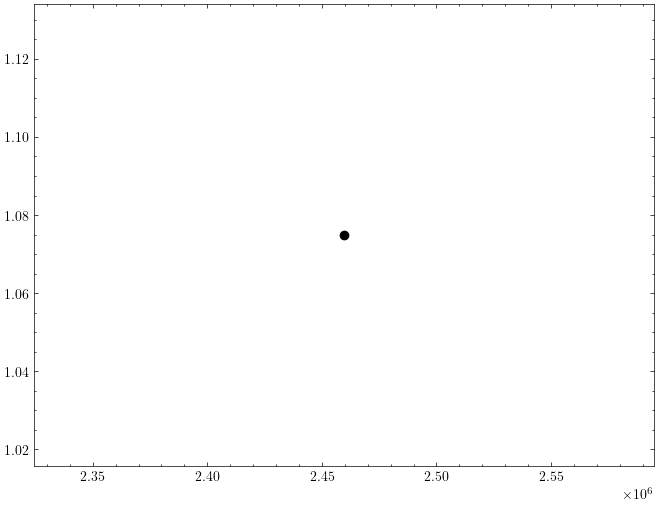

In [36]:
data_ztfg = ztfData[ztfData['filter'] == 'ZTF:g']
fitter_ztfg = OCFitter(data_ztfg['time'].value, data_ztfg['norm_flux'], data_ztfg['norm_ferr'], ORBITAL_PERIOD.value)
mintimes_ztfg, mintimes_err_ztfg = fitter_ztfg.fit_minima(showfirst=True)
midtimes_ztfg, oc_ztfg, oc_err_ztfg = fitter_ztfg.calculate_OC(showplot=True)

# $O - C$ on all data
Using normalized fluxes to determine minima times. Should be compatible since they're all on roughly the same scale, and HJD times should already be calibrated.

In [29]:
allData = vstack([ztfData, iturbideData])
allData.sort('time')
allData

time,mag,err,filter,norm_flux,norm_ferr,obsv_date
,mag,mag,,,mag,
Time,float64,float64,str18,float64,float64,str10
2458228.984821069,17.5840454,0.0197342671,ZTF:g,1.0282138275083825,0.018688744299987674,--
2458234.944095733,17.4334183,0.018555779,ZTF:g,1.1812294877891425,0.020187807339980303,--
2458235.001065248,17.4940319,0.0190106239,ZTF:g,1.1170917385495702,0.01955964147671939,--
2458252.963232793,17.5891399,0.0197770167,ZTF:g,1.023400535775349,0.01864155344375466,--
2458255.9276150335,17.3031044,0.0176594257,ZTF:g,1.3318638767454534,0.021662675584388245,--
2458255.9645266226,16.9123917,0.0152251096,ZTF:r,1.0318182379573217,0.014469026354038484,--
2458258.9544024398,16.8072433,0.0146829495,ZTF:r,1.136743710573925,0.015372749313925446,--
2458261.9687530138,17.5298138,0.0192911923,ZTF:g,1.0808765132361293,0.019204846055618775,--


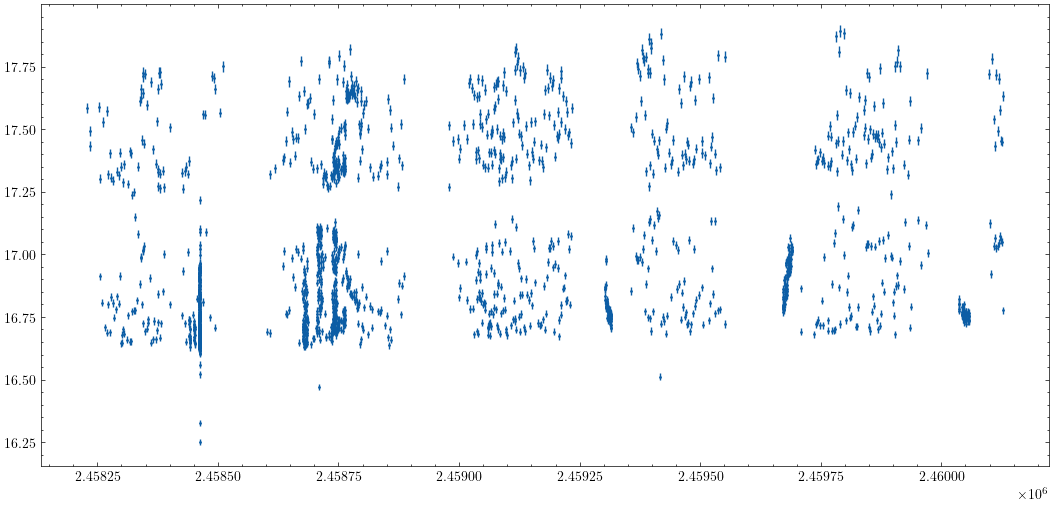

In [19]:
# plt.figure(figsize=(13, 6))
# plt.errorbar(allData['time'].value, allData['norm_flux'], allData['norm_ferr'], marker='.', linestyle='none', markersize=2)

# plt.figure(figsize=(13, 6))
# plt.errorbar(iturbideData['time'].value, iturbideData['norm_flux'], iturbideData['norm_ferr'], marker='.', linestyle='none', markersize=2)

plt.figure(figsize=(13, 6))
plt.errorbar(ztfData['time'].value, ztfData['mag'], ztfData['err'], marker='.', linestyle='none', markersize=2)
plt.show()

In [25]:
# periodChangeData = allData[allData['filter'] == 'ZTF:r']
periodChangeData = ztfData[ztfData['filter'] == 'ZTF:r']

fitter = OCFitter(periodChangeData['time'].value, periodChangeData['mag'].value, periodChangeData['err'].value, ORBITAL_PERIOD.value)
mintimes, mintimes_err = fitter.fit_minima(showfirst=True)
# mintimes, mintimes_err = fitter.fit_minima(showfirst=True, fittype='nonparametric', smoothness=-1)
# mintimes, mintimes_err = fitter.fit_minima(showfirst=True, fittype='poly', order=4)
midtimes, oc, oc_err = fitter.calculate_OC(showplot=True)

Calculating minima times...


LinAlgError: Singular matrix